In [1]:
import mysql.connector
import pandas as pd

In [2]:
def connect():
  connection = mysql.connector.connect(
    host = "localhost",
    user = "root",
    password = "",
    database = "wp-ecommerce"
  )

  cursor = connection.cursor(dictionary = True)

  return connection, cursor

In [3]:
def get_sales_between_two_dates(start_date, end_date):
  _, cursor = connect()

  sql = '''
    SELECT LEFT(date_created, 10) as date, sum(product_net_revenue) as sales
    FROM wp_wc_order_product_lookup
    WHERE date_created BETWEEN (%s) AND (%s)
    GROUP BY date
    ORDER BY date
  '''

  cursor.execute(sql, (start_date, end_date))

  results = cursor.fetchall()

  entries = []
  for row in results:
    entries.append({
      "date": row["date"],
      "sales": row["sales"]
    })
  
  data = pd.DataFrame(entries)

  return data

In [4]:
from datetime import datetime
from datetime import timedelta

def get_last_sale_date():
  _, cursor = connect()

  sql = '''
    SELECT Left(MAX(date_created), 10) date
    FROM wp_wc_order_product_lookup
  '''

  cursor.execute(sql)

  result = cursor.fetchone()

  last_sale_date = datetime.strptime(result["date"], "%Y-%m-%d")

  return last_sale_date

In [5]:
# if last sale date is today
# end_date = datetime.today()

last_sale_date = get_last_sale_date()
start_date = last_sale_date - timedelta(days = 90)
end_date = last_sale_date + timedelta(days = 1, microseconds =  -1)

start_date, end_date

(datetime.datetime(2023, 1, 12, 0, 0),
 datetime.datetime(2023, 4, 12, 23, 59, 59, 999999))

In [6]:
data = get_sales_between_two_dates(start_date, end_date)

data

,date,sales
0,2023-01-12,303866.373686
1,2023-01-13,408098.753614
2,2023-01-14,282464.019749
3,2023-01-15,340937.267067
4,2023-01-16,166830.461281
...,...,...
82,2023-04-08,516294.979440
83,2023-04-09,547243.145301
84,2023-04-10,502081.531535
85,2023-04-11,407430.212356


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    87 non-null     object 
 1   sales   87 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.5+ KB


#### Resample dateset when the corresponding date has no sales data

##### Resample

* The object must have a datetime index
* D "daily data" will downsample if some dates have many rows, their values will be set to the mean
* Create missing dates with None values

##### Then...

* Replace None values of the generated entries with mean values

In [8]:
data["date"] = pd.to_datetime(data["date"])

data = data.set_index("date")

# to reset index
# data = data.reset_index()

print("before resample:", len(data.index))

data = data.resample("D").mean()

data["sales"] = data["sales"].fillna(data["sales"].mean())

print("after resample:", len(data.index))

before resample: 87
after resample: 91


#### Time series' characteristics

* Sideways Trend
* Seasonality, Sales increase at the beginning of each month
* Irrgular fluctuations after the beginning of each month

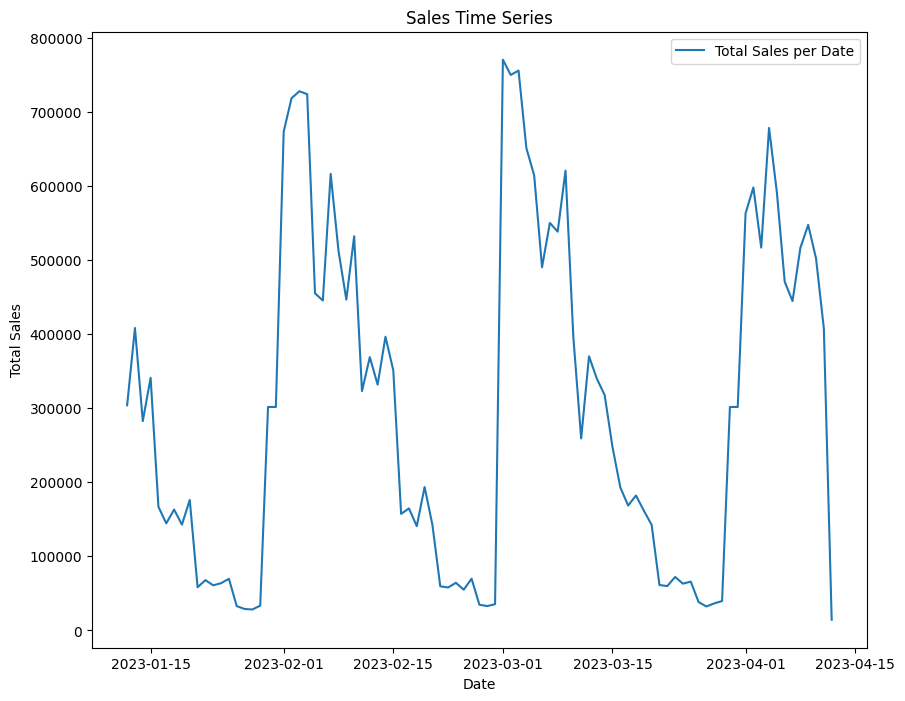

In [9]:
# date is the index
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 8))
plt.title("Sales Time Series")
plt.plot(data["sales"], label = "Total Sales per Date")

plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.legend()
plt.show()

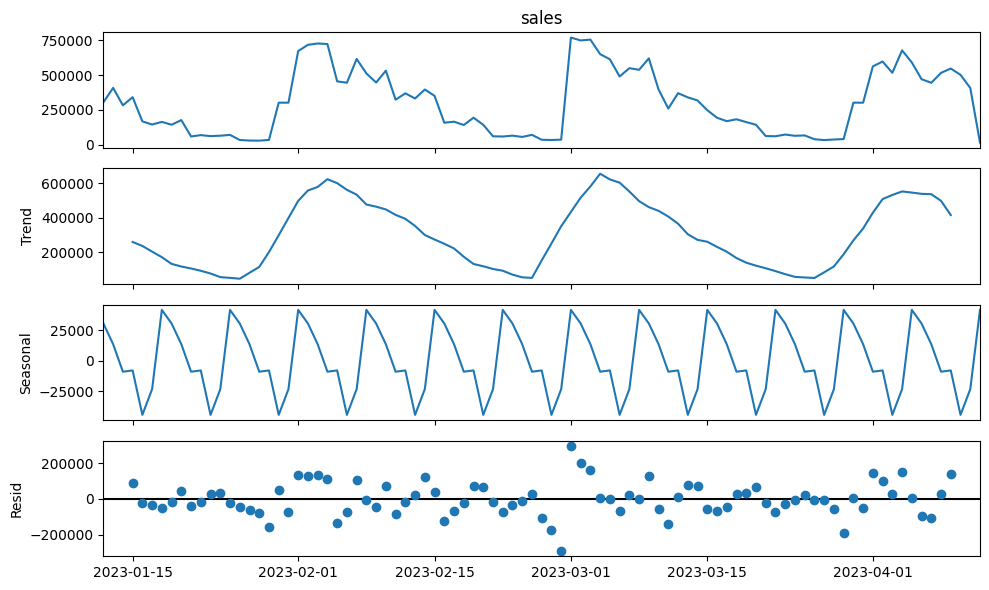

In [10]:
# date is the index
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(data["sales"])

plt.rc("figure", figsize = (10, 6))

# assign to variable or add plt.show() in the next line to avoid duplicating the plotting
figure = result.plot()

In [11]:
data = data.reset_index()

In [12]:
import plotly.express as px

figure = px.line(data, x = "date", y = "sales", title = "Sales Time Series")

figure.show()

In [13]:
figure = px.bar(data, x = "date", y = "sales", title = "Sales Time Series")

figure.show()

Split into train and test datasets

In [14]:
data = data.set_index("date")

In [15]:
diff_days = (end_date - start_date).days

train_end_date = end_date - timedelta(days = 10)
test_start_date = train_end_date + timedelta(days = 0, microseconds = 1)

train_start_date = start_date.strftime("%Y-%m-%d")
train_end_date = train_end_date.strftime("%Y-%m-%d")
train_data = data.loc[train_start_date:train_end_date]

test_start_date = test_start_date.strftime("%Y-%m-%d")
test_end_date = end_date.strftime("%Y-%m-%d")
test_data = data.loc[test_start_date:test_end_date]

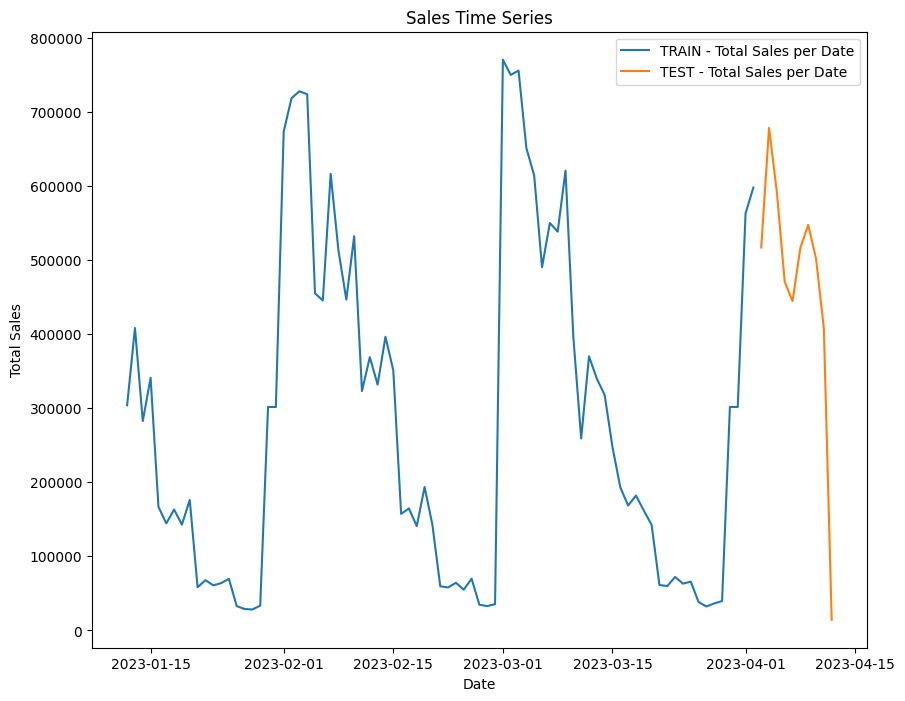

In [16]:
plt.figure(figsize = (10, 8))

plt.title("Sales Time Series")
plt.plot(train_data["sales"], label = "TRAIN - Total Sales per Date")
plt.plot(test_data["sales"], label = "TEST - Total Sales per Date")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.legend()
plt.show()

In [17]:
train_data = train_data.reset_index()
test_data = test_data.reset_index()

**Fitting AutoTS model takes long time and logs a lot of information and warnings**

In [ ]:
from autots import AutoTS

forecast_length = len(test_data)

model = AutoTS(forecast_length, frequency = "infer", ensemble = "simple")

model = model.fit(train_data, date_col = "date", value_col = "sales")

Show predictions for test dataset

In [19]:
prediction = model.predict()

forecast = prediction.forecast

forecast

,0
2023-04-03,309714.139917
2023-04-04,321187.060574
2023-04-05,243101.097810
2023-04-06,244015.823817
2023-04-07,309714.139917
2023-04-08,340884.950114
2023-04-09,262731.558772
2023-04-10,263571.874583
2023-04-11,329097.695966
2023-04-12,340743.111341


In [20]:
test_data = test_data.set_index("date")

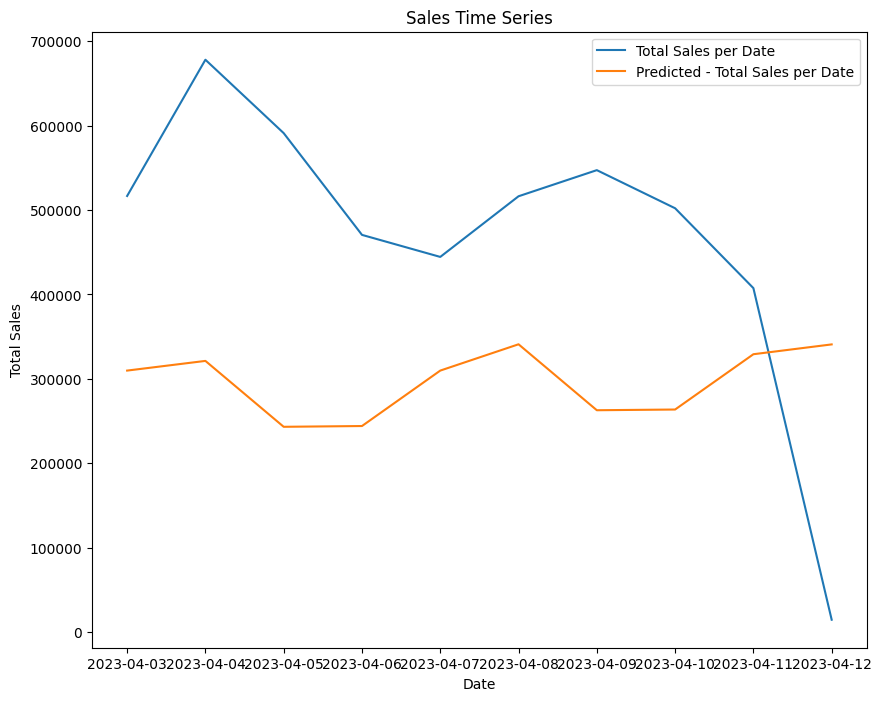

In [29]:
plt.figure(figsize = (10, 8))

plt.title("Sales Time Series")
plt.plot(test_data["sales"], label = "Total Sales per Date")
plt.plot(forecast[0], label = "Predicted - Total Sales per Date")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.legend()
plt.show()

In [22]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(test_data["sales"], forecast[0]))

"Min", round(test_data["sales"].min()), "RMSE", round(rmse), "Max", round(test_data["sales"].max())

('Min', 14482, 'RMSE', 253365, 'Max', 678098)